## Part I: Simulate view of scene with perspective projection

In [1]:
import numpy as np

# Define some random points in 1x1x1 cube centred at (0,0,2): np.random.rand(10,3) - 0.5 + np.array([[0,0,2.0]])

p = np.array([[ 0.12062476, -0.12785722,  1.97609345],
              [ 0.16699898, -0.17195925,  2.04246037],
              [-0.42046153,  0.02247281,  1.61450026],
              [-0.37014299,  0.06171833,  1.53362723],
              [ 0.36308432, -0.42033255,  1.67721814],
              [ 0.25009329, -0.07650547,  2.34388177],
              [ 0.42827347,  0.13925811,  1.95612405],
              [ 0.45347235,  0.42011514,  2.48881573],
              [ 0.18933395, -0.11681953,  1.81291012],
              [-0.24106583,  0.0503234 ,  1.688478  ]])

In [2]:
# Define camera position (0, 0, 0) 

cam_pos = np.array([0, 0, 0])

# Define camera orientation in world coordinates (this camera is aligned to world)

i_f = np.array([[1,0,0]]).T
j_f = np.array([[0,1,0]]).T
k_f = np.array([[0,0,1]]).T

# Define camera parameters

f  = 1          # focal length
bu = bv = 1   # scaling factors
u0 = v0 = 0     # offsets

In [3]:
# Perspective projection

# Note: OpenCV uses right-handed coordinate system instead (for X ^ Y = Z)

def projectPoints(p, cam_pos, i_f, j_f, k_f, f=1, bu=1, bv=1, u0=0, v0=0):
    s = p - cam_pos
    u = ( f * bu * np.dot(s, i_f ))/( np.dot(s, k_f) ) + u0
    v = ( f * bv * np.dot(s, j_f ))/( np.dot(s, k_f) ) + v0
    return u, v

u, v = projectPoints(p, cam_pos, i_f, j_f, k_f, f, bu, bv, u0, v0)

# Image points
# p_f = np.concatenate((u, v), axis = 1)
# p_f.shape

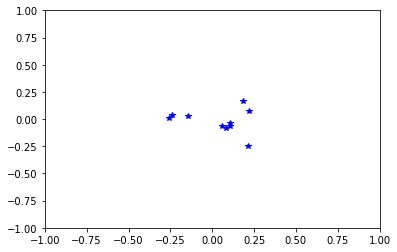

In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot(u, v, 'b*')
plt.axis([-bu, bu, -bv, bv])
plt.show()

### Interactive display of view from different camera positions (translation only)

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt

def translate_camera(x=0, y=0, z=0):
    cam_pos = np.array([x, y, z])
    u, v = projectPoints(p, cam_pos, i_f, j_f, k_f, f, bu, bv, u0, v0)
    
    plt.plot(u, v, 'b*'), plt.axis([-bu, bu, -bv, bv])
    plt.show()
    return np.concatenate((u, v), axis = 1)

In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [7]:
interact(translate_camera, x=(-1.0,+1.0,0.01), y = (-1.0,+1.0,0.01), z = (0.0,+2.0,0.01)) 

A Jupyter Widget

<function __main__.translate_camera>

-------------------------
## Part II: Particle Filter with T as F matrix (assume R, K = I)

1. Set up two camera positions (translation only)
2. Sample possible translation vectors in 3 dimensions, using particle filtering

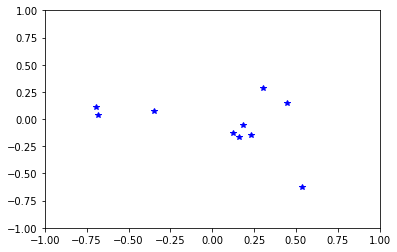

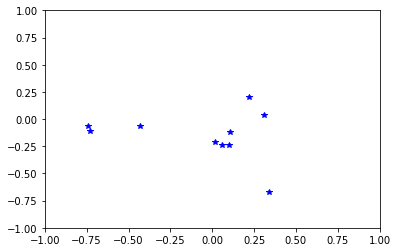

In [8]:
# Set up two camera positions

pts1 = translate_camera(x=0, y=0, z=1)
pts2 = translate_camera(x=0.1, y=0.1, z=0.9)

#### List pts1 and pts2:

In [9]:
pts1

array([[ 0.12357911, -0.13098871],
       [ 0.16019696, -0.16495519],
       [-0.68423328,  0.03657087],
       [-0.69363587,  0.11565813],
       [ 0.53614087, -0.62067527],
       [ 0.18609769, -0.05692872],
       [ 0.44792668,  0.14564858],
       [ 0.30458595,  0.28218075],
       [ 0.23290884, -0.14370535],
       [-0.35014311,  0.07309369]])

In [10]:
pts2

array([[ 0.01916633, -0.21174483],
       [ 0.05864447, -0.23804699],
       [-0.72842735, -0.10850547],
       [-0.74198672, -0.06041671],
       [ 0.33849483, -0.66948071],
       [ 0.10395123, -0.12224371],
       [ 0.31082851,  0.03717187],
       [ 0.22247536,  0.20148034],
       [ 0.09785624, -0.2375037 ],
       [-0.43256227, -0.06300315]])

### 1. Functions
- getEpilineDeviations
- ParticleFilter
- generate_xyz

In [11]:
def getEpilineDeviations(line, pts1):
    ''' 
        Returns squared vertical distances of img 1 points from epipolar line. Shape: (n_points, 1)

        Parameters
        ----------
        line  - coefficients of epiline on img 1, (a, b, c). Shape: (1, 3)
        pts1  - points in img 1. Shape: (n_points, 2)
        
    '''
    # Add one-padding for matrix multiplication
    pts = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
    
    # Compute result of au + bv + c = d. Shape: (n_points, 1)
    d = np.dot(pts, line.T)
    
    # Vertical distance from line is d/b. Compute square of this distance:
    return (d/line[0,1]) ** 2

In [12]:
import cv2

def ParticleFilter(S, sigma, pts1, pts2, epsilon = 1):
    ''' S       - Represents state-weight pairs. Shape: (dim+1, m) 
                  The first dim rows store m sample states, and the last row stores their importance weights. 
        sigma   - Standard deviation of Gaussian used for resampling
        pts1    - Points from first image
        pts2    - Points from second image (used to draw epilines on first image)
        epsilon - Threshold of squared vertical deviation, for counting a point as "near" to an epiline
    '''
    dim = S.shape[0] - 1
    m   = S.shape[1]
    weights = np.zeros((1, m))
    normaliser = 0
    S_new = np.empty((dim+1, 0))
    
    # for debugging 
    score_list = []
    not_match_count = 0
    matches = 0
    
    for i in range(m):
        # Sample with replacement
        ind = np.random.choice(m, 1, p=S[dim,:].tolist())[0]
        
        # Perturb sample state (state represented by translation vector)
        pt = S[:dim,ind]
        t = np.random.normal(loc=pt, scale=sigma, size=None) 
        
        # Compute score of t
        score = 0
        T = np.array([[     0, -t[2],  t[1] ],
                      [  t[2],     0, -t[0] ],
                      [ -t[1],  t[0],     0 ]])
        
        lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, T) # Shape: (n_pts2, 3)
        for j in range(lines1.shape[0]):
            matches += 1
            sqdists = getEpilineDeviations(lines1[j, :], pts1)
            if np.any(sqdists < epsilon): 
                if j != np.argmin(sqdists): 
                    # print("not a match:" + str(j) + " " + str(np.argmin(sqdists)))
                    not_match_count += 1
                score += 1
                
        score_list.append(score)
        
        # Add new point to output S_new
        new_pt = np.array([[*t, score]]).T
        S_new = np.concatenate((S_new, new_pt), axis = 1)
        
        normaliser += score
    
    # Normalise weights in S_new
    # S_new[3,:] = S_new[3,:]/normaliser
    
    # Instead of normalising, use softmax function
    S_new[3,:] = np.exp(S_new[3,:])/np.sum(np.exp(S_new[3,:]))
    
    return S_new, score_list, not_match_count, matches

In [13]:
def generate_xyz(n_samples):
    return np.random.rand(3, n_samples) * 2 - np.array([[1,1,2]]).T

#### Misc: Testing ParticleFilter function

In [14]:
m = 100
S = np.concatenate((generate_xyz(m), 1/m * np.ones((1,m))), axis = 0) 
S_new, score_list, nmc, mc = ParticleFilter(S, 0.02, pts1, pts2, epsilon = 0.0001)

In [15]:
S_new[:, :5]

array([[-2.73919588e-01,  1.79024321e-01,  8.25871153e-01,
         2.81537219e-01, -7.54299977e-01],
       [ 5.70539833e-01,  3.19110510e-01,  3.21814897e-01,
        -4.44391626e-01, -7.40033061e-01],
       [-6.54558846e-01, -1.94255639e+00, -1.62535219e+00,
        -3.11258279e-01, -7.23288493e-01],
       [ 1.70699061e-03,  6.27966752e-04,  1.70699061e-03,
         6.27966752e-04,  4.64008156e-03]])

In [16]:
print(score_list)

[1, 0, 1, 0, 2, 3, 1, 3, 1, 2, 3, 2, 1, 4, 0, 1, 1, 0, 1, 0, 4, 1, 1, 1, 1, 1, 0, 1, 2, 2, 6, 0, 4, 0, 1, 2, 1, 0, 0, 1, 3, 3, 0, 3, 1, 5, 2, 1, 1, 1, 1, 3, 0, 1, 0, 1, 1, 2, 5, 1, 0, 0, 2, 0, 3, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 2, 3, 4, 2, 0, 4, 2, 4, 3, 2, 4, 1, 0, 0, 4, 1, 1, 2, 1, 3, 1, 1, 0, 1]


In [17]:
print(nmc/mc)

0.118


### 2. Visualise uniform sampling of states

In [18]:
# Sample m states. Shape of S: (4, n_samples)
m = 100
S = np.concatenate((generate_xyz(m), 1/m * np.ones((1,m))), axis = 0) 

print("Shape of initial S: " + str(S.shape))

Shape of initial S: (4, 100)


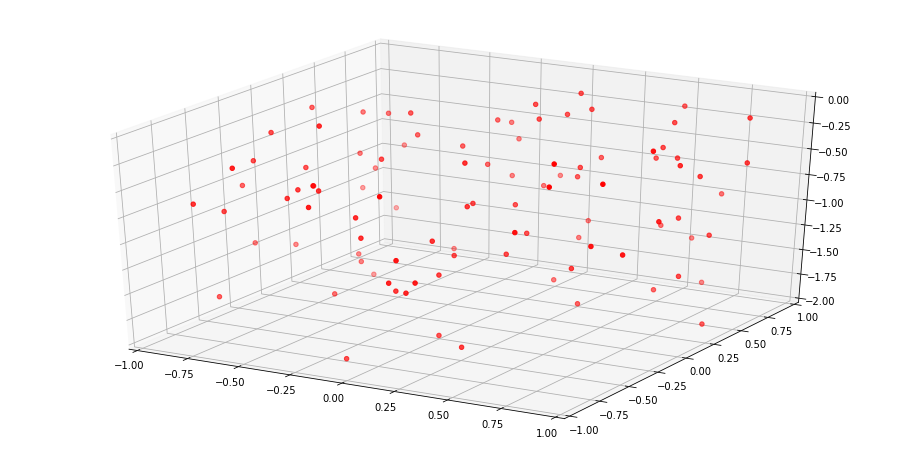

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*S[:3,:], zdir='z', c= 'red')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-2, 0)
plt.show()

# Note: axes are x, y, z, in order from left to right

### 3. Run Particle Filter (20 iterations) 

- sigma, the resampling Gaussian standard deviation, decreases over iterations
- non-match ratio counts cases where a point deemed "near" to an epiline is not a ground truth match

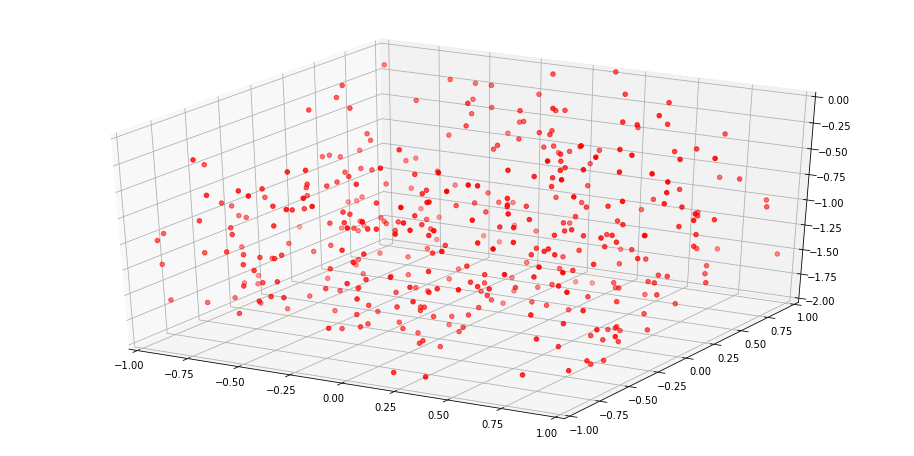

[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 1, 0, 3, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 3, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 4, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 

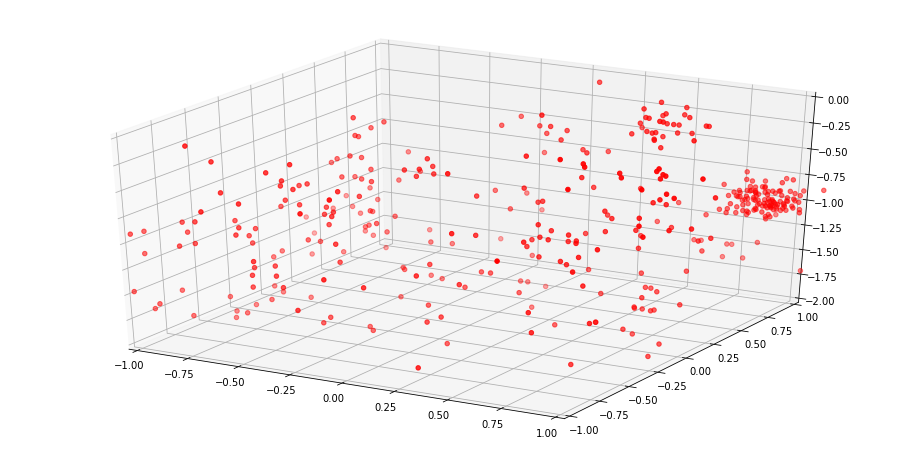

[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 1, 1, 1, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 3, 0, 2, 1, 7, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 3, 1, 2, 5, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 7, 3, 1, 0, 0, 0, 3, 6, 4, 6, 0, 0, 0, 0, 2, 3, 1, 1, 1, 3, 2, 1, 0, 0, 0, 2, 3, 0, 0, 3, 0, 1, 0, 1, 3, 2, 1, 0, 1, 0, 0, 2, 2, 0, 0, 1, 9, 0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 2, 1, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 3, 4, 0, 0, 1, 2, 1, 0, 0, 3, 0, 2, 2, 0, 0, 0, 1, 0, 1, 2, 3, 1, 0, 0, 1, 0, 0, 1, 1, 4, 3, 0, 1, 0, 0, 0, 1, 0, 0, 1, 2, 1, 1, 0, 6, 0, 5, 1, 1, 0, 0, 0, 0, 10, 1, 1, 0, 1, 2, 0, 7, 1, 1, 4, 6, 0, 2, 3, 1, 1, 0, 2, 0, 3, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 3, 1, 1, 5, 1, 0, 0, 5, 0, 2, 0, 0, 0, 0, 1, 2, 6, 1, 0, 4, 2, 0, 0, 1, 6, 1, 1, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 1,

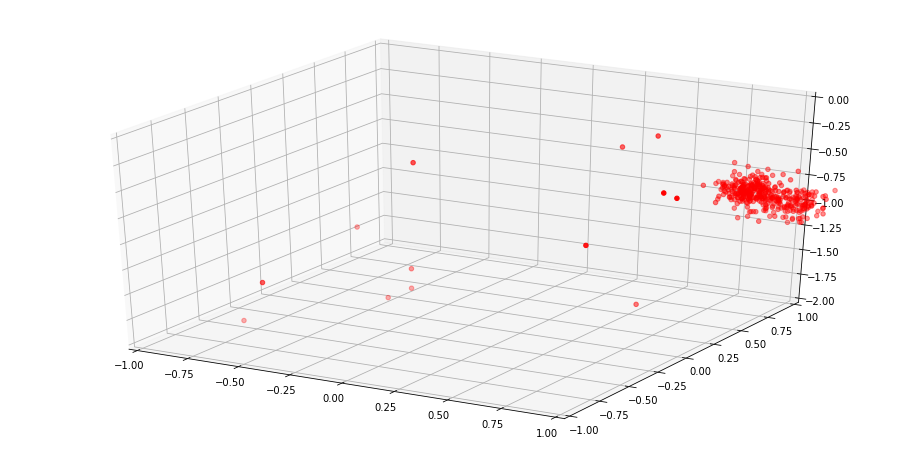

[1, 3, 1, 0, 1, 0, 2, 1, 2, 2, 1, 6, 3, 4, 1, 6, 9, 7, 10, 3, 6, 0, 1, 3, 7, 2, 1, 3, 2, 6, 0, 0, 1, 3, 3, 3, 6, 7, 8, 4, 1, 3, 1, 0, 2, 6, 1, 9, 0, 0, 0, 1, 3, 6, 5, 0, 6, 7, 6, 2, 0, 0, 3, 6, 4, 0, 2, 1, 4, 3, 1, 2, 0, 6, 6, 3, 1, 0, 2, 1, 2, 1, 0, 1, 5, 0, 1, 1, 0, 3, 3, 2, 0, 0, 2, 7, 2, 0, 0, 5, 3, 1, 6, 6, 0, 2, 0, 1, 0, 1, 6, 0, 7, 1, 1, 0, 0, 2, 6, 5, 1, 7, 1, 6, 0, 5, 1, 1, 1, 7, 0, 7, 1, 1, 7, 2, 3, 4, 6, 2, 3, 7, 6, 1, 2, 2, 2, 0, 2, 5, 6, 7, 0, 1, 3, 6, 3, 4, 0, 1, 1, 1, 0, 1, 7, 6, 6, 0, 10, 0, 0, 1, 6, 1, 6, 1, 0, 1, 0, 2, 2, 6, 0, 4, 0, 4, 1, 1, 7, 6, 7, 2, 1, 0, 5, 0, 1, 4, 0, 0, 5, 0, 0, 6, 3, 3, 1, 1, 6, 4, 1, 2, 2, 3, 0, 2, 6, 1, 7, 3, 6, 7, 2, 3, 2, 1, 3, 1, 1, 1, 2, 7, 2, 3, 4, 2, 0, 1, 0, 3, 1, 3, 3, 6, 1, 2, 1, 6, 0, 2, 2, 4, 2, 6, 6, 1, 0, 0, 0, 2, 1, 1, 0, 1, 5, 0, 2, 1, 5, 7, 2, 1, 2, 2, 1, 6, 3, 1, 7, 2, 1, 7, 1, 6, 1, 3, 0, 0, 1, 6, 0, 1, 1, 7, 1, 0, 2, 2, 1, 6, 7, 1, 1, 3, 0, 0, 1, 0, 0, 1, 0, 0, 2, 8, 4, 2, 1, 0, 7, 0, 1, 5, 0, 1, 1, 4, 1, 6, 1, 2, 0, 0, 0

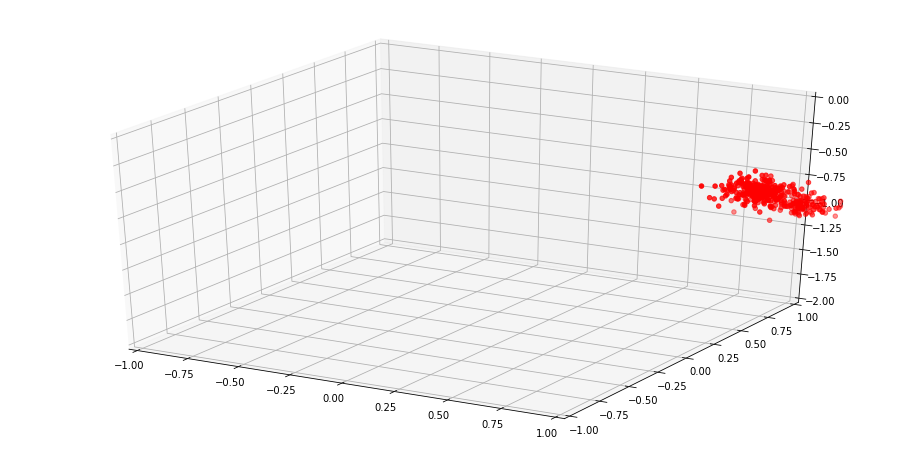

[6, 1, 1, 1, 5, 4, 1, 0, 7, 1, 0, 7, 8, 0, 3, 3, 6, 5, 1, 6, 6, 0, 7, 2, 3, 7, 1, 2, 7, 6, 0, 0, 1, 1, 1, 3, 6, 1, 6, 3, 0, 0, 7, 1, 6, 1, 3, 1, 1, 2, 5, 1, 8, 1, 1, 1, 7, 0, 0, 6, 1, 3, 6, 6, 5, 0, 3, 2, 2, 1, 2, 2, 7, 7, 1, 6, 6, 0, 7, 7, 3, 0, 6, 7, 2, 0, 3, 9, 3, 0, 1, 1, 6, 0, 1, 0, 1, 1, 2, 0, 0, 6, 5, 0, 1, 0, 1, 6, 3, 5, 1, 5, 3, 2, 4, 0, 1, 0, 1, 2, 7, 0, 0, 1, 1, 4, 6, 2, 6, 7, 2, 10, 6, 1, 1, 7, 1, 0, 1, 2, 1, 6, 1, 0, 4, 5, 6, 0, 3, 0, 0, 7, 2, 6, 1, 0, 0, 6, 1, 4, 0, 2, 0, 0, 6, 6, 7, 0, 1, 1, 0, 0, 1, 6, 6, 6, 0, 6, 3, 2, 6, 2, 5, 1, 7, 6, 1, 0, 1, 9, 4, 0, 6, 2, 2, 0, 8, 1, 0, 0, 1, 6, 6, 0, 1, 6, 6, 5, 7, 5, 2, 7, 0, 6, 1, 4, 5, 5, 0, 4, 5, 6, 0, 0, 6, 0, 2, 3, 6, 1, 0, 1, 3, 7, 0, 0, 7, 3, 0, 10, 0, 7, 1, 6, 5, 1, 7, 7, 6, 1, 6, 7, 0, 5, 6, 6, 4, 2, 2, 4, 1, 5, 1, 5, 0, 2, 8, 7, 1, 6, 7, 1, 4, 1, 7, 1, 6, 2, 6, 6, 1, 1, 8, 1, 2, 0, 2, 0, 4, 0, 0, 4, 2, 3, 3, 0, 7, 1, 7, 2, 1, 1, 6, 1, 1, 2, 6, 5, 2, 5, 1, 5, 0, 1, 2, 7, 6, 6, 7, 0, 0, 6, 0, 1, 6, 0, 6, 2, 7, 7, 0, 3, 0

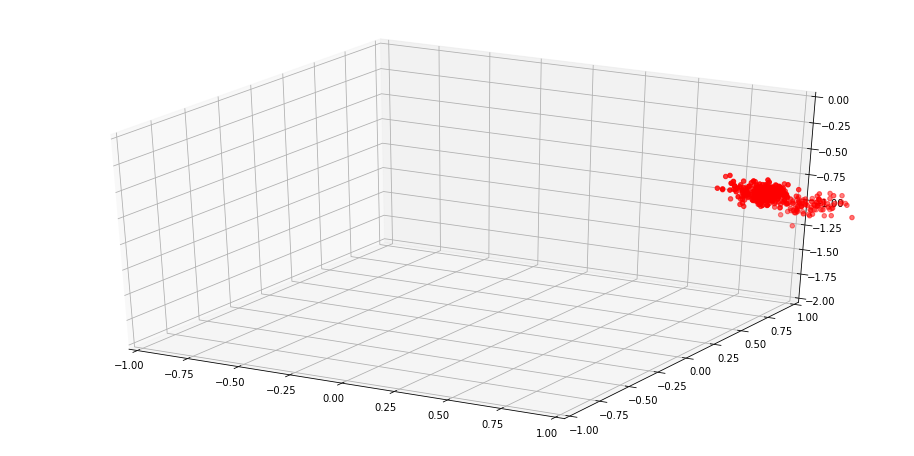

[4, 1, 1, 6, 1, 1, 0, 0, 7, 0, 6, 4, 1, 6, 6, 2, 0, 0, 0, 4, 2, 1, 5, 1, 4, 2, 2, 0, 2, 4, 3, 6, 7, 6, 4, 1, 2, 6, 7, 6, 2, 1, 3, 1, 4, 7, 8, 1, 6, 6, 0, 8, 0, 10, 7, 6, 6, 7, 2, 0, 3, 0, 7, 2, 6, 0, 1, 1, 6, 5, 5, 7, 2, 1, 6, 6, 0, 0, 2, 0, 1, 0, 1, 4, 10, 1, 6, 7, 8, 1, 4, 0, 1, 2, 2, 4, 6, 7, 1, 7, 3, 6, 4, 6, 7, 8, 7, 0, 1, 6, 1, 8, 6, 2, 3, 3, 6, 0, 2, 0, 3, 1, 7, 4, 2, 7, 2, 8, 7, 1, 7, 4, 1, 0, 1, 6, 6, 5, 6, 4, 7, 2, 3, 6, 1, 0, 2, 6, 1, 6, 7, 1, 1, 1, 7, 2, 2, 8, 7, 2, 0, 6, 6, 1, 2, 2, 5, 6, 0, 3, 3, 7, 6, 0, 0, 6, 0, 0, 4, 0, 0, 1, 5, 6, 7, 0, 10, 2, 1, 3, 7, 2, 7, 1, 7, 1, 0, 6, 0, 0, 2, 8, 1, 0, 6, 7, 4, 0, 7, 7, 7, 0, 0, 5, 3, 5, 1, 10, 6, 2, 7, 0, 7, 3, 7, 6, 7, 8, 5, 4, 1, 2, 0, 1, 2, 1, 1, 3, 6, 1, 7, 0, 3, 0, 2, 1, 2, 6, 0, 7, 1, 6, 1, 6, 2, 4, 0, 6, 2, 2, 6, 1, 8, 3, 0, 8, 0, 0, 1, 0, 6, 6, 7, 0, 0, 0, 1, 10, 0, 4, 1, 0, 5, 1, 6, 3, 1, 1, 1, 4, 0, 0, 0, 1, 0, 2, 7, 5, 2, 0, 2, 6, 2, 2, 6, 0, 5, 7, 0, 10, 6, 7, 5, 2, 0, 1, 1, 0, 1, 1, 1, 2, 7, 1, 3, 8, 1, 5, 1, 5, 0, 

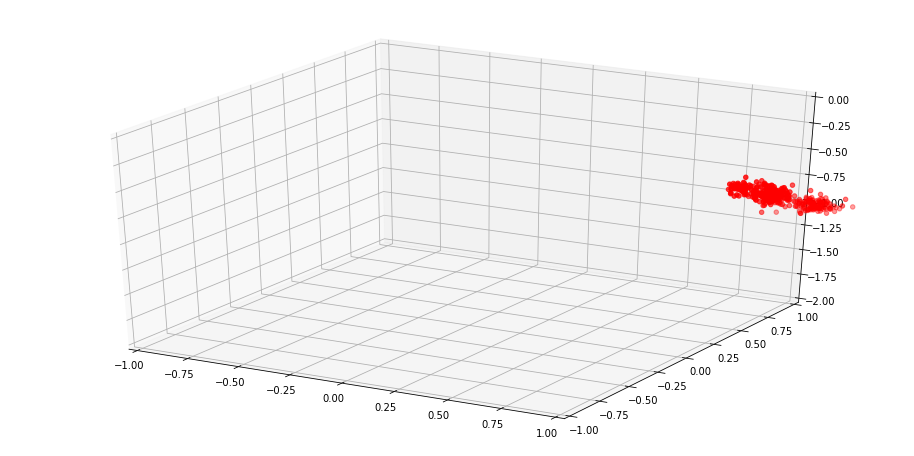

[7, 1, 7, 0, 5, 6, 8, 7, 7, 4, 6, 6, 2, 6, 3, 2, 1, 0, 5, 7, 7, 5, 7, 0, 8, 3, 5, 2, 8, 3, 8, 6, 2, 6, 1, 0, 7, 1, 2, 8, 0, 7, 8, 5, 7, 7, 7, 9, 6, 0, 7, 8, 3, 0, 3, 3, 7, 1, 0, 7, 1, 4, 7, 0, 2, 3, 7, 6, 0, 5, 0, 6, 2, 2, 6, 3, 3, 3, 0, 5, 3, 7, 6, 6, 0, 1, 2, 1, 7, 1, 0, 2, 8, 1, 6, 6, 2, 1, 1, 2, 5, 1, 1, 7, 9, 5, 3, 8, 7, 3, 0, 6, 2, 3, 0, 1, 6, 7, 6, 2, 6, 0, 8, 5, 3, 1, 0, 2, 7, 6, 6, 2, 1, 5, 7, 1, 5, 2, 7, 6, 0, 0, 2, 3, 7, 2, 1, 7, 6, 4, 2, 2, 6, 1, 7, 10, 1, 1, 6, 4, 0, 2, 2, 3, 5, 7, 1, 8, 7, 7, 2, 10, 1, 5, 3, 3, 5, 6, 7, 6, 1, 1, 6, 3, 0, 6, 3, 5, 2, 1, 5, 7, 3, 1, 7, 0, 6, 3, 1, 7, 1, 0, 7, 7, 2, 7, 7, 0, 7, 6, 6, 7, 2, 0, 5, 10, 7, 7, 2, 5, 2, 2, 7, 7, 6, 2, 6, 2, 1, 3, 2, 7, 7, 1, 7, 6, 2, 1, 5, 3, 6, 7, 8, 7, 3, 3, 1, 3, 0, 7, 7, 9, 8, 8, 6, 6, 1, 4, 4, 7, 7, 7, 2, 1, 5, 7, 1, 8, 6, 0, 5, 7, 2, 6, 2, 1, 1, 4, 1, 7, 7, 10, 0, 1, 1, 2, 4, 2, 7, 10, 0, 6, 6, 1, 1, 7, 2, 1, 1, 8, 6, 8, 8, 4, 8, 6, 7, 6, 7, 5, 5, 8, 4, 1, 7, 2, 6, 6, 6, 3, 7, 1, 6, 7, 5, 6, 0, 4, 7, 2, 8, 7

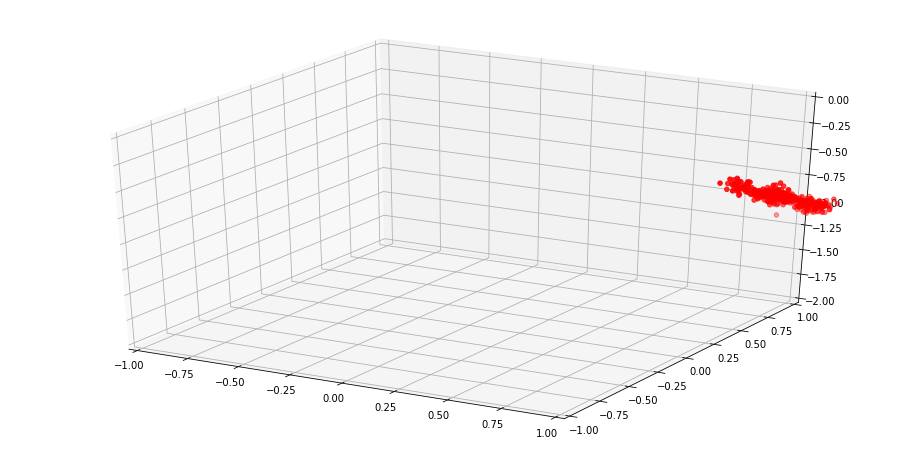

[8, 8, 7, 5, 7, 7, 6, 0, 1, 8, 2, 4, 7, 1, 5, 5, 7, 7, 7, 6, 3, 3, 6, 7, 8, 8, 2, 3, 10, 5, 7, 10, 10, 6, 8, 8, 3, 7, 7, 1, 2, 8, 8, 8, 7, 10, 7, 2, 7, 7, 3, 7, 2, 7, 6, 8, 6, 7, 2, 7, 6, 8, 1, 10, 2, 0, 10, 9, 7, 4, 1, 7, 1, 1, 8, 7, 5, 6, 7, 1, 0, 1, 7, 0, 1, 1, 7, 2, 3, 3, 7, 8, 7, 4, 6, 1, 1, 3, 7, 8, 1, 0, 10, 3, 8, 6, 1, 1, 1, 8, 1, 2, 6, 6, 7, 7, 6, 6, 7, 6, 1, 1, 4, 1, 5, 7, 7, 1, 5, 3, 6, 4, 1, 0, 4, 1, 7, 7, 1, 2, 0, 3, 3, 0, 6, 7, 1, 7, 2, 6, 1, 1, 10, 6, 1, 1, 7, 7, 2, 2, 7, 8, 7, 6, 1, 2, 6, 7, 5, 0, 9, 6, 6, 0, 7, 3, 4, 2, 5, 1, 7, 7, 7, 8, 3, 7, 3, 10, 6, 8, 2, 6, 10, 1, 6, 8, 2, 6, 6, 7, 5, 5, 6, 5, 0, 5, 0, 6, 7, 1, 10, 2, 1, 6, 1, 3, 9, 2, 7, 6, 10, 0, 7, 3, 2, 8, 7, 0, 3, 10, 0, 10, 4, 0, 7, 7, 3, 6, 0, 0, 1, 9, 3, 5, 7, 9, 6, 3, 7, 3, 3, 6, 0, 7, 2, 4, 7, 2, 7, 0, 5, 1, 10, 6, 5, 2, 6, 7, 7, 5, 5, 1, 8, 9, 8, 6, 6, 1, 10, 2, 1, 7, 0, 1, 4, 1, 7, 2, 8, 5, 6, 7, 2, 7, 1, 1, 7, 9, 1, 2, 7, 6, 9, 2, 6, 5, 4, 7, 3, 6, 2, 7, 2, 7, 7, 7, 3, 5, 0, 1, 1, 7, 4, 5, 7, 1, 7, 7,

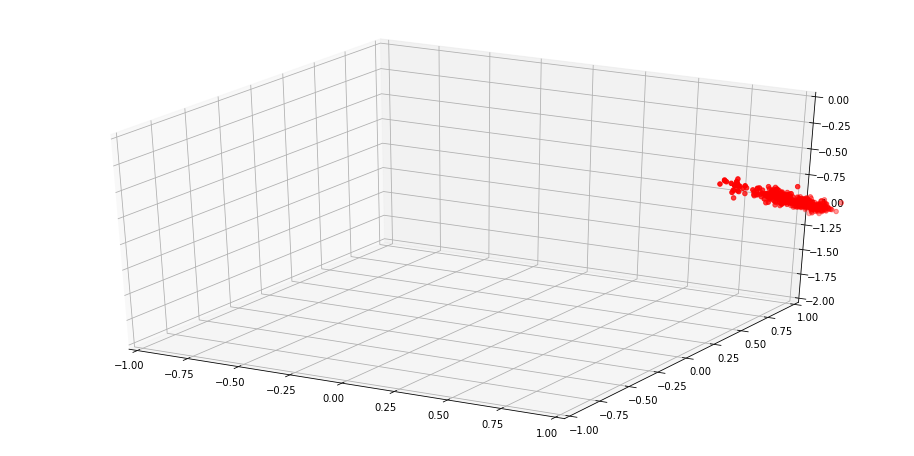

[8, 8, 8, 6, 2, 0, 7, 6, 8, 9, 7, 7, 10, 7, 7, 1, 6, 8, 8, 6, 7, 8, 2, 10, 2, 5, 7, 6, 7, 6, 7, 8, 7, 4, 7, 0, 7, 7, 8, 7, 7, 7, 10, 1, 7, 7, 5, 6, 1, 10, 7, 6, 6, 7, 7, 6, 8, 7, 0, 4, 4, 8, 5, 9, 7, 6, 10, 7, 5, 8, 2, 7, 8, 7, 7, 8, 5, 4, 1, 1, 0, 6, 4, 1, 4, 5, 6, 8, 6, 8, 7, 7, 0, 10, 2, 10, 1, 1, 7, 7, 1, 6, 8, 1, 7, 7, 8, 1, 7, 7, 3, 10, 5, 7, 5, 8, 7, 6, 7, 7, 7, 6, 7, 6, 6, 3, 7, 7, 1, 8, 2, 7, 3, 8, 5, 6, 7, 0, 9, 6, 6, 10, 10, 6, 0, 0, 6, 1, 7, 3, 8, 8, 6, 5, 8, 5, 10, 3, 0, 6, 3, 5, 6, 7, 3, 6, 7, 7, 4, 7, 3, 4, 6, 8, 10, 9, 7, 7, 1, 3, 8, 7, 1, 1, 2, 1, 1, 1, 9, 7, 8, 7, 0, 8, 1, 0, 7, 1, 1, 7, 6, 3, 4, 7, 7, 7, 7, 6, 0, 7, 7, 7, 5, 1, 8, 1, 8, 7, 7, 6, 7, 6, 3, 7, 10, 7, 8, 7, 6, 0, 7, 7, 1, 1, 1, 7, 2, 6, 8, 8, 7, 7, 9, 7, 9, 7, 7, 7, 7, 5, 1, 8, 10, 10, 7, 1, 6, 7, 3, 9, 7, 8, 2, 2, 2, 7, 10, 1, 2, 0, 0, 1, 7, 0, 7, 2, 6, 7, 6, 8, 8, 6, 3, 6, 7, 2, 3, 1, 0, 7, 8, 7, 1, 3, 2, 7, 1, 9, 2, 8, 7, 6, 5, 4, 6, 6, 6, 6, 6, 7, 7, 7, 1, 7, 2, 7, 7, 7, 3, 3, 6, 8, 7, 8, 7, 7, 5, 7,

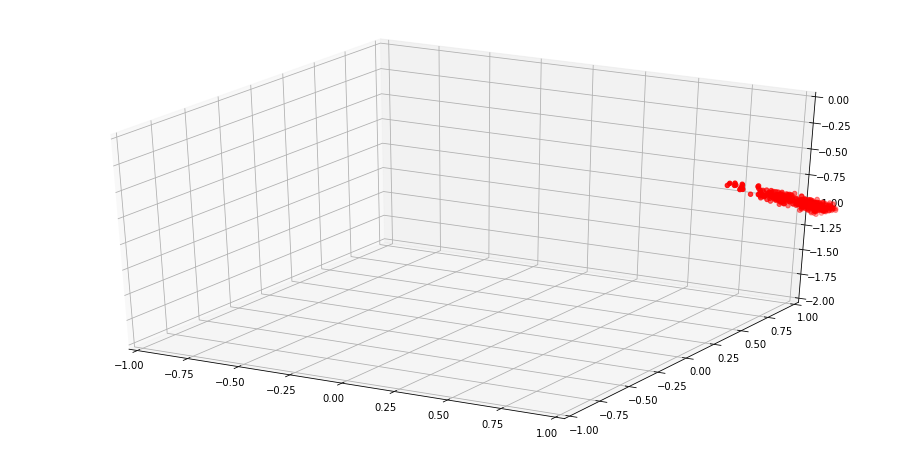

[8, 1, 8, 7, 8, 7, 8, 7, 1, 7, 6, 9, 4, 6, 2, 5, 8, 7, 9, 7, 10, 8, 3, 7, 7, 1, 0, 7, 1, 8, 6, 7, 10, 7, 7, 6, 8, 8, 4, 1, 8, 7, 7, 7, 6, 7, 2, 5, 7, 7, 10, 7, 2, 10, 7, 7, 10, 2, 1, 1, 3, 7, 2, 10, 4, 7, 10, 9, 7, 9, 9, 7, 10, 6, 7, 6, 3, 10, 4, 2, 7, 3, 6, 9, 7, 0, 9, 7, 10, 7, 7, 4, 7, 7, 7, 8, 2, 6, 7, 8, 8, 8, 7, 10, 7, 9, 10, 8, 7, 7, 4, 8, 7, 4, 3, 7, 7, 9, 8, 8, 8, 6, 6, 7, 1, 5, 7, 10, 8, 7, 7, 2, 8, 4, 8, 7, 7, 7, 8, 6, 6, 3, 7, 10, 7, 3, 7, 4, 6, 6, 7, 10, 7, 1, 6, 2, 10, 1, 7, 5, 4, 7, 10, 4, 10, 7, 8, 7, 2, 2, 7, 8, 0, 9, 7, 7, 7, 8, 7, 6, 3, 10, 7, 7, 7, 7, 8, 7, 7, 6, 7, 7, 6, 2, 6, 4, 7, 1, 8, 9, 10, 9, 6, 8, 1, 7, 8, 8, 3, 6, 0, 7, 7, 6, 7, 6, 7, 9, 1, 1, 6, 6, 6, 8, 7, 0, 9, 5, 7, 4, 1, 10, 8, 8, 10, 7, 10, 7, 4, 4, 7, 6, 7, 10, 4, 7, 7, 10, 6, 8, 8, 2, 7, 7, 8, 10, 10, 4, 5, 5, 7, 7, 7, 7, 8, 7, 7, 3, 3, 6, 7, 5, 7, 10, 6, 0, 8, 7, 7, 7, 8, 8, 1, 2, 10, 7, 7, 7, 7, 1, 9, 8, 7, 6, 6, 7, 7, 7, 8, 8, 8, 6, 10, 4, 6, 5, 7, 7, 9, 7, 7, 3, 3, 6, 7, 2, 7, 6, 3, 7, 8, 7, 7, 

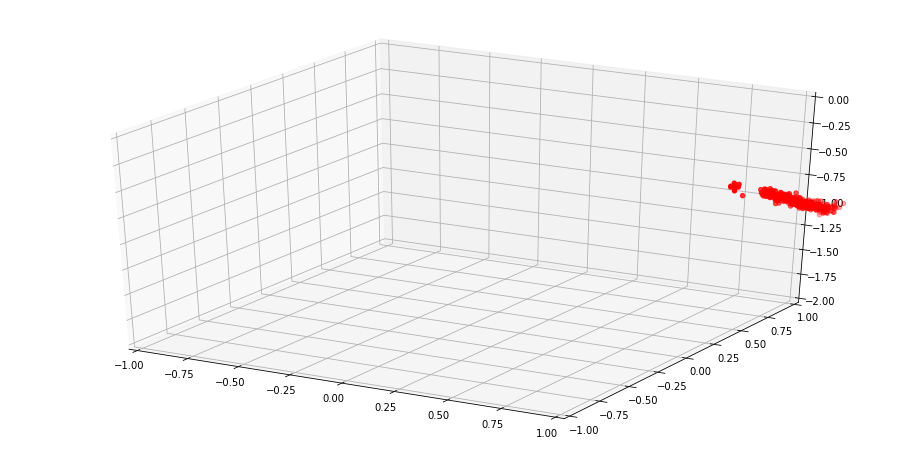

[10, 2, 2, 8, 2, 7, 6, 10, 7, 8, 10, 10, 5, 7, 7, 10, 8, 3, 7, 7, 7, 8, 7, 6, 6, 2, 3, 7, 3, 4, 8, 7, 7, 7, 8, 7, 5, 7, 7, 9, 8, 10, 8, 6, 7, 10, 8, 10, 8, 9, 9, 6, 9, 6, 5, 4, 3, 7, 7, 7, 6, 2, 8, 6, 7, 10, 8, 8, 8, 10, 10, 4, 10, 6, 8, 10, 7, 8, 5, 7, 7, 3, 6, 10, 8, 6, 7, 7, 7, 8, 7, 8, 7, 7, 9, 7, 7, 8, 8, 8, 10, 6, 3, 6, 8, 2, 7, 10, 2, 10, 7, 6, 7, 3, 6, 5, 8, 7, 7, 9, 8, 7, 9, 8, 6, 8, 7, 9, 7, 6, 10, 4, 10, 8, 7, 5, 10, 7, 7, 3, 8, 6, 8, 7, 8, 7, 7, 9, 2, 7, 7, 8, 6, 6, 7, 7, 7, 7, 8, 7, 8, 7, 7, 7, 8, 7, 7, 7, 5, 7, 9, 3, 3, 0, 4, 7, 0, 10, 3, 1, 6, 3, 8, 10, 8, 6, 6, 8, 4, 9, 7, 8, 1, 7, 6, 7, 7, 7, 6, 1, 2, 3, 7, 3, 8, 9, 7, 5, 7, 8, 7, 8, 4, 10, 7, 9, 9, 7, 8, 7, 8, 8, 7, 6, 8, 10, 7, 10, 7, 7, 7, 8, 8, 7, 6, 10, 9, 10, 7, 7, 6, 7, 7, 10, 8, 7, 7, 8, 9, 8, 7, 9, 7, 3, 8, 7, 1, 9, 8, 6, 7, 7, 9, 5, 8, 8, 7, 8, 5, 9, 8, 4, 9, 7, 7, 7, 10, 9, 7, 7, 0, 8, 7, 10, 10, 7, 7, 2, 8, 10, 9, 5, 7, 9, 2, 10, 6, 7, 3, 10, 10, 7, 8, 8, 7, 7, 8, 1, 8, 7, 2, 7, 7, 3, 7, 7, 7, 9, 8, 2, 5, 1

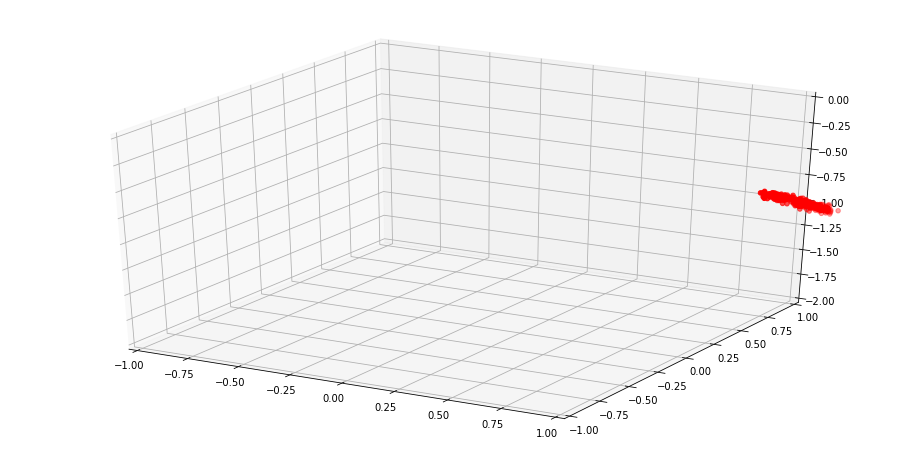

[6, 10, 10, 7, 5, 7, 7, 8, 3, 8, 7, 5, 8, 7, 7, 10, 7, 2, 3, 8, 8, 6, 7, 7, 8, 4, 8, 5, 8, 8, 9, 5, 8, 8, 7, 5, 8, 8, 9, 10, 8, 7, 7, 10, 10, 10, 10, 8, 7, 7, 10, 7, 6, 8, 7, 9, 8, 8, 7, 8, 8, 9, 9, 10, 10, 8, 8, 9, 7, 7, 9, 7, 10, 7, 9, 8, 7, 8, 10, 10, 7, 10, 10, 0, 4, 10, 9, 10, 7, 9, 7, 8, 4, 7, 6, 7, 6, 7, 7, 10, 9, 8, 4, 7, 8, 8, 7, 7, 8, 7, 8, 7, 7, 6, 10, 8, 7, 8, 7, 8, 3, 7, 8, 8, 3, 6, 7, 8, 6, 10, 7, 8, 10, 8, 7, 7, 9, 10, 7, 8, 8, 7, 7, 5, 9, 7, 3, 10, 8, 7, 7, 7, 7, 9, 7, 7, 10, 7, 7, 8, 8, 9, 8, 7, 7, 10, 7, 9, 10, 7, 3, 9, 9, 9, 8, 10, 8, 10, 7, 9, 7, 9, 8, 10, 8, 10, 7, 7, 8, 2, 8, 8, 7, 7, 8, 10, 7, 10, 10, 7, 8, 7, 10, 7, 5, 8, 10, 4, 7, 5, 10, 7, 10, 10, 7, 6, 9, 8, 6, 1, 7, 6, 7, 7, 8, 10, 8, 8, 7, 4, 9, 8, 6, 8, 9, 10, 5, 7, 7, 7, 10, 9, 6, 7, 9, 6, 5, 7, 7, 7, 10, 8, 9, 9, 5, 6, 3, 9, 8, 8, 10, 7, 2, 9, 9, 9, 8, 3, 8, 8, 7, 8, 9, 10, 8, 10, 10, 4, 8, 8, 8, 8, 9, 8, 8, 7, 9, 8, 6, 9, 7, 7, 4, 8, 7, 7, 10, 7, 8, 7, 10, 10, 6, 7, 8, 2, 7, 7, 8, 7, 10, 10, 8, 3, 8, 10

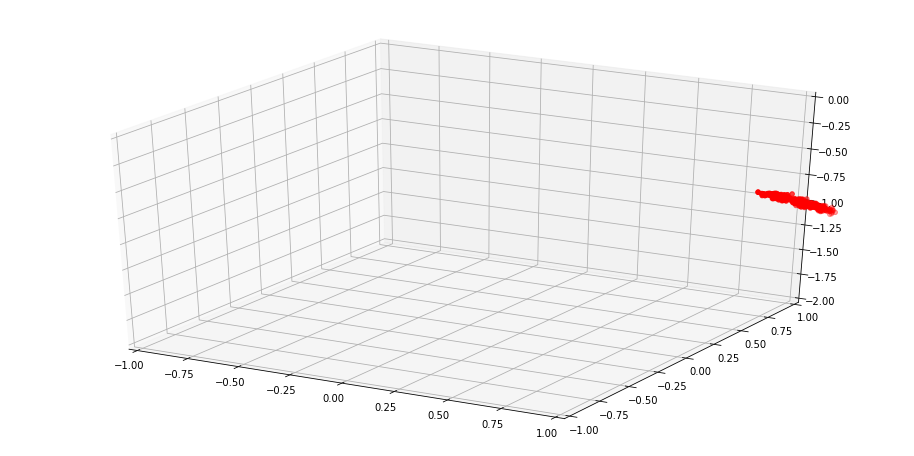

[7, 8, 7, 8, 7, 8, 9, 8, 10, 6, 7, 10, 10, 7, 3, 7, 6, 8, 7, 9, 8, 7, 7, 8, 9, 7, 8, 7, 8, 8, 9, 7, 10, 7, 8, 10, 10, 9, 6, 8, 8, 10, 7, 8, 7, 7, 8, 7, 8, 8, 8, 9, 9, 7, 7, 3, 7, 9, 7, 9, 8, 10, 10, 10, 10, 8, 8, 8, 10, 10, 8, 9, 10, 8, 8, 10, 8, 10, 7, 8, 10, 5, 3, 7, 7, 10, 10, 10, 7, 7, 7, 10, 7, 7, 8, 10, 8, 8, 8, 10, 7, 7, 8, 10, 7, 10, 10, 8, 10, 10, 8, 10, 8, 7, 10, 7, 9, 7, 10, 10, 9, 10, 8, 6, 8, 10, 7, 7, 10, 8, 9, 8, 9, 7, 8, 8, 7, 10, 8, 8, 7, 7, 7, 8, 7, 10, 9, 9, 10, 5, 7, 3, 10, 7, 10, 5, 8, 10, 7, 10, 8, 7, 7, 8, 9, 6, 7, 10, 8, 8, 10, 10, 10, 7, 7, 7, 10, 8, 10, 8, 7, 8, 8, 8, 8, 7, 10, 10, 7, 7, 10, 8, 3, 10, 5, 8, 10, 7, 7, 8, 9, 8, 7, 7, 7, 7, 7, 10, 10, 7, 5, 3, 6, 7, 8, 8, 7, 10, 8, 8, 10, 7, 10, 7, 8, 10, 10, 10, 8, 8, 8, 8, 9, 8, 10, 7, 10, 9, 9, 8, 10, 6, 8, 8, 7, 10, 10, 8, 10, 8, 7, 7, 7, 2, 7, 8, 8, 10, 7, 7, 8, 8, 10, 10, 8, 7, 10, 8, 10, 3, 9, 10, 9, 8, 7, 8, 8, 10, 7, 10, 8, 8, 7, 7, 6, 8, 8, 10, 7, 10, 9, 7, 7, 8, 7, 8, 8, 10, 10, 9, 7, 7, 4, 7, 7, 8, 5,

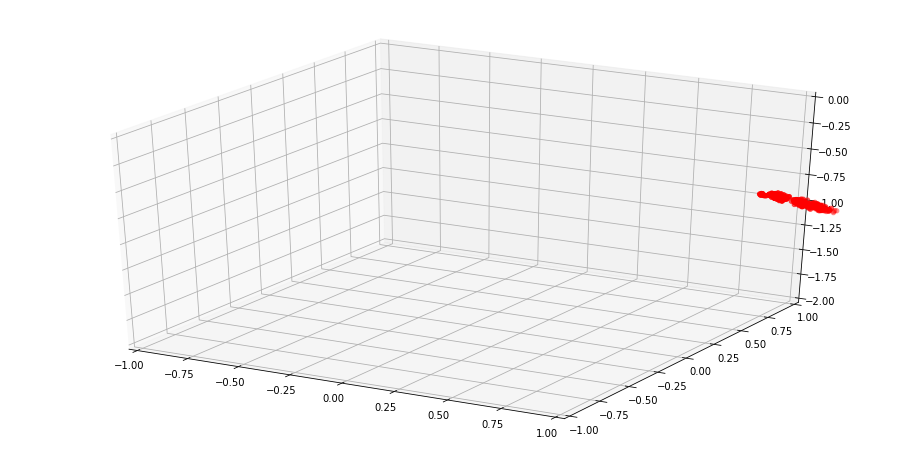

[10, 10, 10, 8, 10, 8, 8, 10, 10, 9, 7, 10, 10, 10, 8, 8, 9, 5, 8, 5, 8, 9, 8, 10, 6, 7, 8, 8, 8, 8, 8, 8, 7, 10, 8, 9, 9, 8, 10, 10, 10, 10, 8, 7, 8, 7, 8, 7, 8, 7, 7, 8, 7, 9, 10, 5, 7, 7, 8, 4, 9, 8, 7, 10, 8, 8, 7, 9, 9, 7, 8, 10, 10, 7, 7, 8, 10, 10, 7, 7, 7, 10, 10, 9, 10, 8, 10, 7, 8, 7, 7, 8, 8, 7, 8, 9, 10, 10, 8, 8, 9, 10, 8, 8, 8, 10, 10, 9, 9, 9, 9, 9, 7, 10, 10, 10, 7, 7, 10, 10, 8, 10, 10, 6, 10, 8, 8, 8, 8, 10, 7, 7, 7, 9, 7, 7, 10, 9, 9, 8, 8, 9, 10, 10, 3, 8, 8, 9, 8, 10, 9, 7, 8, 10, 10, 10, 8, 10, 8, 7, 10, 8, 10, 8, 8, 10, 9, 10, 7, 8, 8, 10, 10, 8, 10, 10, 7, 8, 8, 5, 8, 8, 9, 10, 9, 10, 8, 7, 8, 10, 8, 9, 7, 8, 8, 8, 7, 8, 9, 10, 5, 7, 8, 10, 10, 10, 10, 10, 10, 8, 10, 8, 7, 10, 8, 8, 8, 4, 8, 7, 8, 7, 7, 10, 10, 7, 10, 9, 5, 9, 6, 9, 6, 10, 8, 8, 8, 10, 7, 7, 7, 3, 8, 7, 9, 9, 10, 8, 7, 8, 9, 6, 9, 7, 7, 8, 10, 10, 7, 8, 9, 9, 8, 10, 8, 7, 10, 10, 7, 8, 7, 9, 7, 8, 10, 7, 7, 7, 7, 9, 7, 7, 9, 5, 7, 8, 10, 10, 8, 7, 10, 8, 10, 10, 8, 8, 7, 10, 10, 10, 7, 10, 10, 1

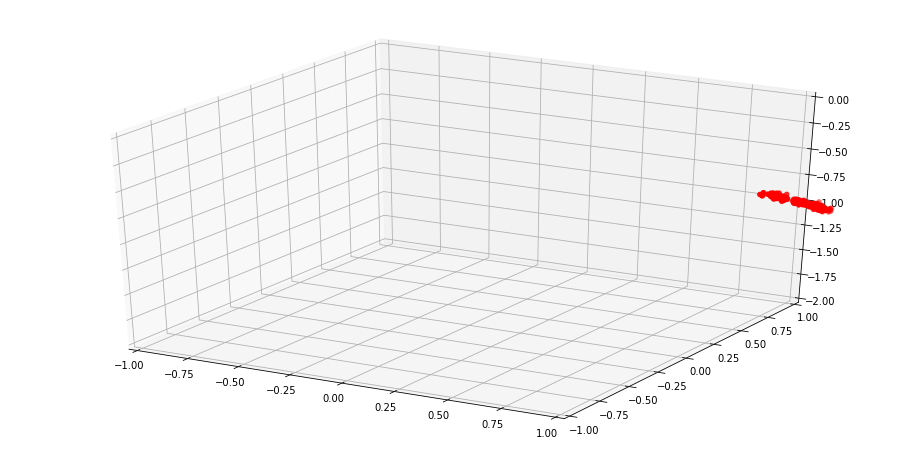

[9, 10, 9, 8, 7, 10, 8, 10, 8, 8, 9, 8, 8, 8, 10, 9, 10, 5, 10, 8, 10, 10, 10, 10, 10, 10, 7, 10, 8, 7, 10, 10, 7, 8, 10, 10, 8, 10, 10, 10, 10, 8, 7, 8, 10, 10, 7, 9, 10, 8, 7, 7, 10, 6, 2, 3, 10, 9, 8, 10, 10, 10, 10, 10, 7, 8, 9, 9, 8, 10, 10, 8, 10, 9, 9, 8, 9, 8, 10, 10, 8, 10, 8, 10, 10, 10, 10, 7, 10, 8, 9, 7, 9, 10, 9, 7, 10, 8, 9, 10, 10, 10, 10, 8, 9, 10, 8, 8, 10, 8, 10, 9, 10, 8, 8, 8, 8, 7, 7, 10, 8, 10, 9, 10, 10, 10, 10, 10, 7, 9, 8, 8, 7, 10, 8, 10, 10, 7, 10, 7, 10, 10, 8, 10, 10, 8, 8, 8, 10, 5, 10, 8, 9, 6, 10, 10, 7, 8, 7, 6, 10, 8, 10, 10, 10, 8, 10, 8, 8, 9, 9, 10, 9, 8, 8, 10, 8, 9, 9, 10, 8, 10, 6, 8, 9, 10, 8, 8, 9, 10, 8, 10, 10, 7, 10, 10, 10, 8, 8, 10, 10, 8, 10, 8, 8, 7, 10, 8, 8, 10, 8, 7, 10, 10, 8, 8, 10, 10, 9, 8, 8, 9, 10, 10, 8, 7, 7, 8, 7, 10, 10, 9, 8, 10, 8, 10, 7, 8, 8, 8, 7, 10, 8, 10, 8, 10, 10, 8, 7, 10, 9, 7, 8, 9, 10, 9, 8, 10, 8, 10, 10, 8, 7, 8, 10, 10, 10, 10, 10, 8, 9, 5, 10, 8, 8, 10, 6, 10, 7, 10, 10, 6, 8, 10, 9, 10, 10, 7, 9, 8, 7, 8,

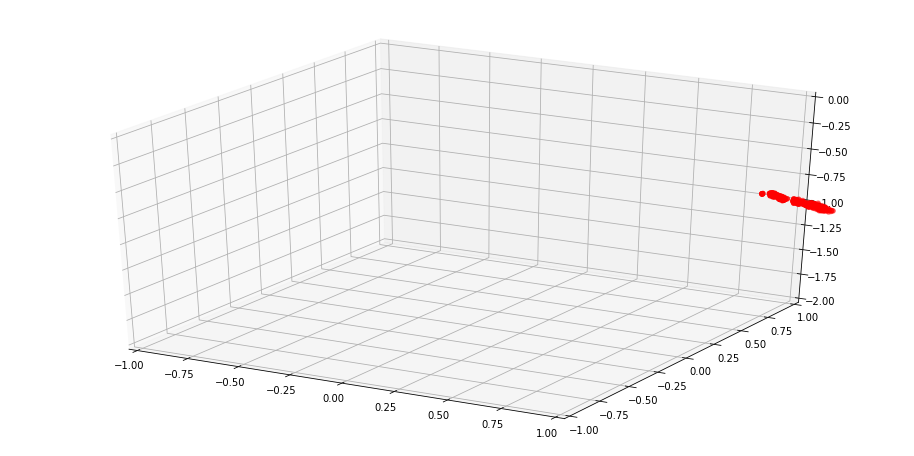

[4, 7, 8, 9, 9, 10, 10, 8, 7, 9, 10, 10, 10, 8, 8, 10, 10, 7, 10, 9, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 8, 9, 10, 9, 10, 8, 9, 10, 8, 8, 10, 10, 10, 8, 10, 8, 10, 8, 10, 9, 8, 10, 8, 7, 10, 7, 10, 10, 10, 10, 8, 9, 8, 10, 9, 10, 8, 8, 10, 10, 10, 10, 10, 10, 8, 9, 10, 10, 10, 10, 10, 10, 9, 9, 10, 9, 10, 5, 9, 9, 10, 10, 10, 6, 8, 9, 9, 8, 10, 8, 10, 8, 9, 9, 10, 10, 10, 9, 10, 7, 10, 9, 10, 10, 5, 8, 10, 10, 9, 10, 10, 9, 10, 10, 10, 7, 10, 9, 6, 8, 10, 9, 9, 10, 10, 8, 10, 8, 10, 10, 10, 8, 8, 8, 10, 9, 10, 10, 8, 10, 8, 10, 10, 8, 8, 2, 8, 10, 5, 7, 10, 7, 7, 10, 8, 6, 10, 10, 10, 9, 9, 10, 9, 8, 9, 10, 10, 10, 8, 8, 9, 8, 9, 9, 10, 10, 10, 7, 5, 5, 10, 5, 8, 10, 10, 10, 10, 8, 8, 10, 8, 10, 9, 10, 8, 8, 7, 9, 10, 9, 10, 2, 10, 10, 8, 7, 8, 8, 7, 9, 10, 10, 8, 10, 8, 8, 7, 10, 10, 10, 8, 10, 10, 8, 10, 10, 8, 9, 9, 10, 8, 10, 8, 8, 8, 8, 10, 10, 8, 8, 8, 10, 10, 9, 10, 8, 10, 9, 10, 7, 10, 10, 10, 8, 8, 9, 8, 10, 10, 10, 10, 8, 10, 10, 10, 8, 8, 10, 6, 5, 10, 8, 8

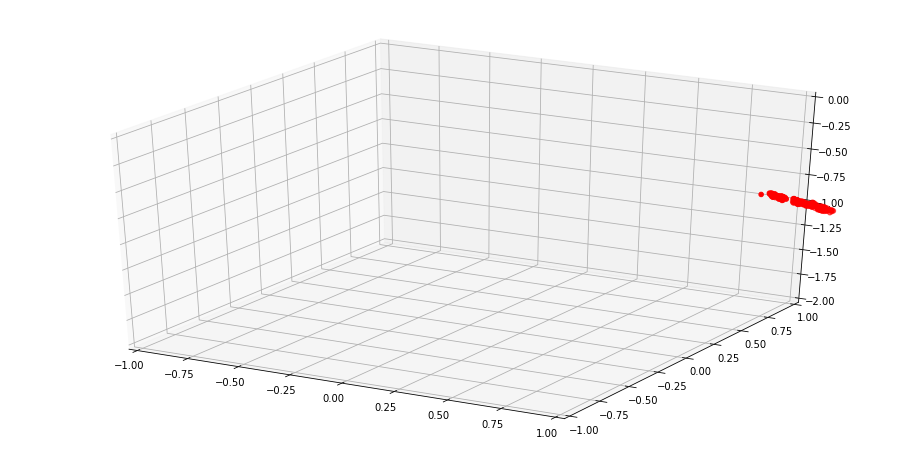

[10, 10, 9, 10, 10, 10, 5, 10, 10, 10, 10, 8, 10, 8, 10, 10, 8, 10, 7, 8, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 7, 8, 10, 10, 8, 10, 10, 10, 10, 10, 9, 8, 8, 9, 8, 8, 8, 10, 9, 9, 9, 7, 7, 9, 10, 10, 10, 9, 10, 9, 9, 10, 9, 10, 10, 10, 10, 8, 8, 10, 10, 10, 10, 10, 10, 8, 7, 10, 10, 10, 9, 9, 10, 10, 7, 10, 8, 8, 8, 10, 10, 10, 10, 8, 10, 10, 10, 5, 10, 8, 9, 9, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 8, 10, 10, 9, 10, 10, 8, 10, 9, 8, 10, 10, 10, 10, 9, 10, 8, 9, 10, 10, 10, 10, 10, 7, 10, 8, 10, 8, 10, 9, 10, 10, 8, 10, 9, 10, 9, 10, 10, 8, 10, 8, 10, 9, 10, 9, 10, 8, 9, 10, 10, 6, 10, 10, 7, 7, 10, 10, 9, 10, 10, 10, 10, 10, 10, 9, 8, 10, 9, 10, 9, 8, 8, 10, 10, 9, 10, 10, 8, 8, 8, 9, 10, 8, 10, 10, 8, 10, 10, 8, 10, 7, 8, 10, 10, 8, 8, 10, 8, 9, 10, 10, 10, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 8, 8, 7, 10, 10, 8, 8, 10, 10, 9, 10, 10, 8, 9, 7, 9, 9, 9, 10, 10, 10, 10, 10, 9, 8, 10, 10, 10, 10, 10, 8, 8, 10, 9, 10, 7, 9, 9, 9, 8, 9, 9, 10, 10, 9, 9, 10, 8

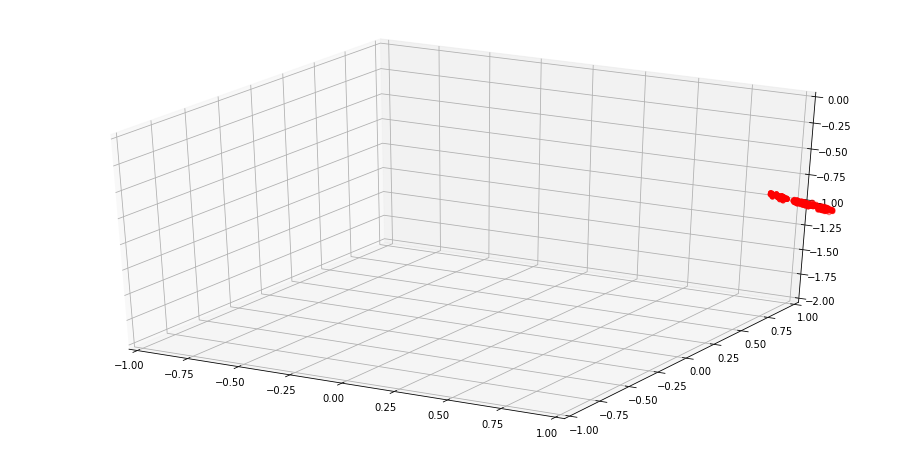

[10, 9, 10, 7, 8, 10, 9, 9, 10, 10, 7, 7, 10, 10, 9, 10, 10, 9, 8, 10, 10, 8, 10, 10, 10, 10, 10, 9, 10, 7, 10, 9, 8, 10, 10, 8, 10, 10, 8, 7, 10, 8, 10, 8, 10, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 9, 9, 10, 10, 10, 10, 10, 10, 8, 9, 9, 10, 9, 10, 8, 10, 10, 9, 10, 10, 10, 7, 10, 8, 9, 10, 9, 10, 10, 8, 10, 9, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 8, 8, 10, 8, 9, 10, 9, 8, 8, 10, 9, 10, 8, 9, 10, 9, 10, 8, 8, 10, 10, 10, 8, 10, 8, 9, 10, 10, 10, 9, 8, 10, 7, 8, 9, 10, 10, 10, 10, 9, 7, 8, 7, 8, 10, 8, 8, 10, 10, 10, 8, 10, 10, 10, 9, 10, 10, 10, 10, 9, 10, 9, 10, 10, 10, 8, 10, 10, 10, 9, 8, 10, 10, 9, 9, 10, 9, 9, 10, 10, 10, 10, 10, 10, 8, 10, 10, 8, 10, 10, 9, 10, 9, 8, 9, 9, 10, 8, 10, 8, 9, 8, 10, 9, 10, 9, 10, 10, 10, 10, 9, 10, 10, 10, 10, 9, 7, 8, 10, 10, 8, 10, 10, 10, 8, 10, 10, 10, 8, 10, 8, 10, 10, 10, 9, 10, 10, 10, 10, 10, 8, 10, 9, 9, 9, 9, 10, 7, 10, 9, 8, 10, 8, 10, 10, 10, 10, 8, 10, 10, 10, 10, 8, 8, 8, 9, 9, 9, 10, 7, 10, 10, 10, 8, 1

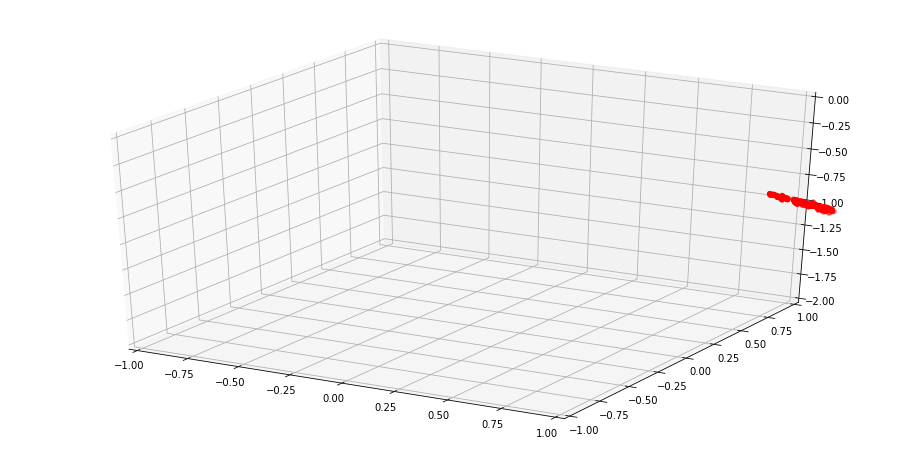

[10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 8, 10, 10, 10, 10, 10, 9, 10, 10, 9, 7, 8, 9, 10, 10, 9, 10, 9, 10, 10, 10, 9, 10, 9, 10, 10, 10, 7, 10, 10, 7, 10, 6, 10, 10, 8, 10, 9, 10, 8, 8, 10, 10, 10, 9, 10, 10, 9, 8, 10, 10, 8, 10, 10, 10, 10, 10, 10, 9, 10, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 10, 8, 10, 10, 8, 10, 10, 9, 9, 10, 8, 8, 8, 8, 10, 8, 10, 10, 10, 9, 10, 10, 10, 9, 9, 9, 10, 10, 8, 10, 10, 10, 8, 10, 10, 8, 9, 10, 10, 10, 9, 8, 6, 10, 8, 8, 9, 10, 8, 8, 9, 10, 8, 10, 10, 9, 10, 10, 9, 10, 8, 10, 10, 10, 7, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 10, 10, 10, 10, 8, 8, 10, 9, 8, 8, 8, 10, 10, 10, 8, 10, 10, 10, 9, 10, 10, 8, 10, 10, 8, 10, 10, 9, 9, 10, 10, 10, 8, 10, 10, 10, 10, 8, 10, 9, 10, 8, 10, 8, 10, 10, 10, 10, 8, 10, 10, 7, 9, 10, 8, 10, 10, 10, 10, 8, 10, 10, 9, 10, 10, 9, 10, 9, 9, 10, 10, 8, 10, 9, 10, 10, 10, 8, 9, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 7, 10, 10, 10, 10, 10, 10, 9, 8, 10, 10, 10, 10, 10, 10,

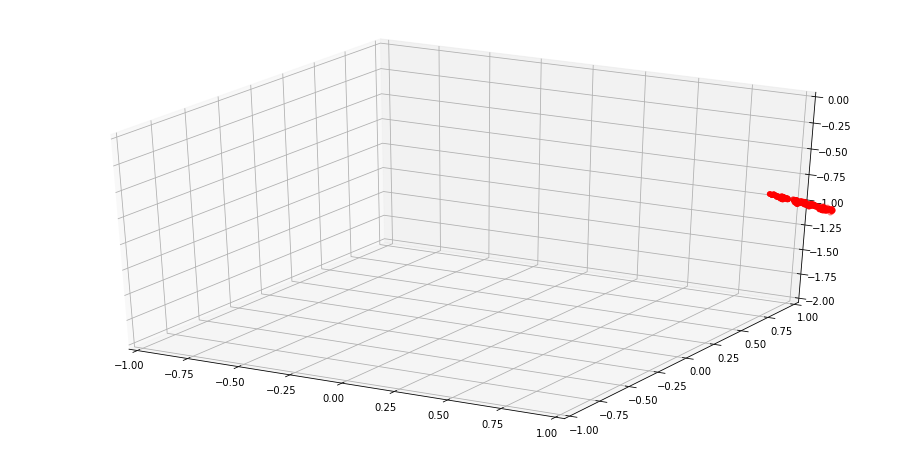

[9, 10, 10, 9, 8, 10, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 9, 8, 10, 9, 10, 8, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 8, 10, 10, 10, 10, 10, 10, 10, 9, 8, 10, 10, 10, 9, 10, 10, 6, 10, 10, 10, 9, 10, 10, 10, 8, 10, 9, 10, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 9, 9, 8, 9, 10, 10, 10, 10, 10, 8, 9, 8, 10, 10, 8, 10, 10, 8, 10, 10, 8, 5, 10, 9, 10, 10, 9, 9, 9, 10, 9, 9, 9, 10, 10, 10, 10, 10, 10, 9, 9, 8, 10, 10, 10, 10, 9, 8, 10, 10, 9, 10, 8, 5, 10, 10, 8, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 8, 8, 10, 8, 9, 10, 10, 10, 10, 8, 10, 10, 9, 10, 10, 10, 10, 10, 10, 9, 10, 9, 8, 10, 10, 8, 9, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 8, 10, 1

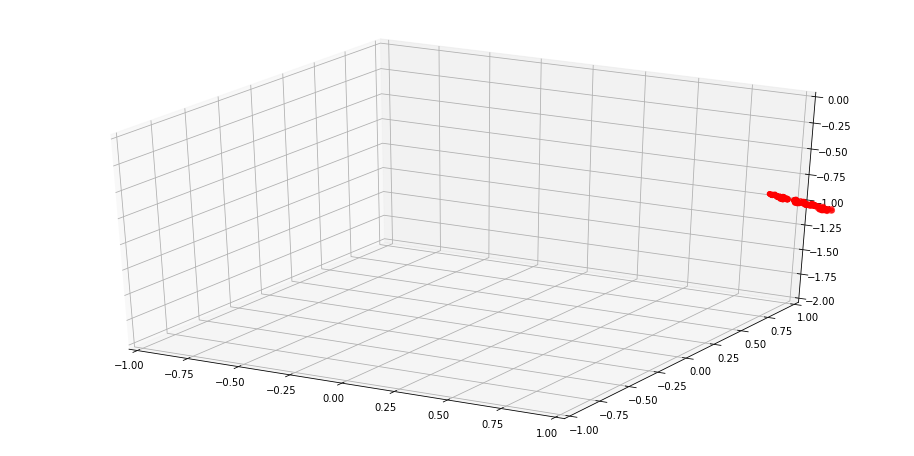

[9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 9, 10, 8, 10, 10, 10, 10, 10, 10, 8, 10, 9, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 8, 10, 8, 10, 10, 10, 9, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 9, 9, 10, 10, 9, 9, 8, 10, 10, 9, 10, 10, 10, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 9, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 9, 10, 8, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 9, 10, 10, 8, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 8, 10, 10, 9, 10, 10, 10, 10, 10, 10, 9, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 9, 8, 10, 10, 10, 9, 9, 10, 10, 10, 10, 8, 10, 10, 9, 10, 10, 9, 10, 10, 10, 10, 8, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 8, 10, 10, 8, 9, 9, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 9, 10, 10, 

In [20]:
iterations = 20

m = 400
S = np.concatenate((generate_xyz(m), 1/m * np.ones((1,m))), axis = 0) 

S_new = S
e = 0.00001
sigma = 0.1

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, epsilon = e)
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*S_new[:3,:], zdir='z', c= 'red')
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-2, 0)
    plt.show()

    #e *= 0.8
    sigma *= 0.8  # Decrease sigma over iterations
    
    print(score_list)
    print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
    print("Sigma: " + str(sigma))
    

### 4. Recover solution from Particle Filter

In [21]:
# Print average and median
ave = np.average(S_new[:3, :], axis = 1)
t   = np.median(S_new[:3, :], axis = 1)
print("Average: " + str(ave))
print("Median:  " + str(t))

Average: [ 1.03157402  1.03115794 -1.03132283]
Median:  [ 1.03057181  1.0354856  -1.02997071]


In [22]:
# Compare median t with ground truth (0.1, 0.1, -0.1) by normalising both vectors
gt = np.array([0.1, 0.1, -0.1])

print("Solution t:   " + str(t/np.linalg.norm(t)))
print("Ground truth: " + str(gt/np.linalg.norm(gt)))
print("Difference:   " + str(t/np.linalg.norm(t) - gt/np.linalg.norm(gt)))

Solution t:   [ 0.57654438  0.57929336 -0.5762081 ]
Ground truth: [ 0.57735027  0.57735027 -0.57735027]
Difference:   [-0.00080589  0.00194309  0.00114216]


In [23]:
# Construct T from median solution t, check that (pts1)' T (pts2) = 0

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

T = np.array([[     0, -t[2],  t[1] ],
              [  t[2],     0, -t[0] ],
              [ -t[1],  t[0],     0 ]])

for i in range(pts1_uvf.shape[0]):
    print(pts1_uvf[i, :] @ T @ pts2_uvf[i, :].T)

0.0005272829616544961
0.0005161157302056019
0.00015652118932518722
0.00016081244043764098
0.001060659160049271
0.00041376819460164915
0.0006908765634671687
0.0004043223590671219
0.0006884185289844913
0.00037272574244950896


In [24]:
# Ground truth check of (pts1)' T (pts2) = 0 for comparison

t = np.array([0.1, 0.1, -0.1])

T = np.array([[     0, -t[2],  t[1] ],
              [  t[2],     0, -t[0] ],
              [ -t[1],  t[0],     0 ]])

for i in range(10):
    print(pts1_uvf[i, :] @ T @ pts2_uvf[i, :].T)

0.0
0.0
1.3877787807814457e-17
1.3877787807814457e-17
1.3877787807814457e-17
0.0
-3.469446951953614e-18
3.469446951953614e-18
0.0
0.0
